In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

上一节中，我们介绍了如何用密集连接的神经网络将向量输入划分为两个互斥的类别。但如果类别不止两个，要怎么做？

本节你会构建一个网络，将路透社新闻划分为 46 个互斥的主题。因为有多个类别，所以这是多分类（multiclass classification）问题的一个例子。因为每个数据点只能划分到一个类别，所以更具体地说，这是单标签、多分类（single-label, multiclass classification）问题的一个例子。如果每个数据点可以划分到多个类别（主题），那它就是一个多标签、多分类（multilabel, multiclass classification）问题。

## The Reuters dataset


本节使用路透社数据集，它包含许多短新闻及其对应的主题，由路透社在 1986 年发布。它是一个简单的、广泛使用的文本分类数据集。它包括 46 个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少 10 个样本。

与 IMDB 和 MNIST 类似，路透社数据集也内置为 Keras 的一部分。我们来看一下。

In [6]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


与 IMDB 数据集一样，参数 num_words=10000 将数据限定为前 10 000 个最常出现的单词。 我们有 8982 个训练样本和 2246 个测试样本。（这里下载可能会失败几次，不翻墙可以下的）

In [7]:
len(train_data)

8982

In [8]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [9]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [10]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [11]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [12]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [13]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


将标签向量化有两种方法：你可以将标签列表转换为整数张量，或者使用 one-hot 编码。

one-hot 编码是分类数据广泛使用的一种格式，也叫分类编码（categorical encoding）。

6.1 节给出了 one-hot 编码的详细解释。在这个例子中，标签的 one-hot 编码就是将每个标签表示为全零向量，只有标签索引对应的元素为 1。其代码实现如下。

In [14]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

注意，Keras 内置方法可以实现这个操作，你在 MNIST 例子中已经见过这种方法。

In [15]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


这个主题分类问题与前面的电影评论分类问题类似，两个例子都是试图对简短的文本片段进行分类。但这个问题有一个新的约束条件：输出类别的数量从 2 个变为 46 个。输出空间的维度要大得多。

对于前面用过的 Dense 层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。上一个例子使用了 16 维的中间层，但对这个例子来说 16 维空间可能太小了，无法学会区分 46 个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。

出于这个原因，下面将使用维度更大的层，包含 64 个单元。

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


关于这个架构还应该注意另外两点。

* 网络的最后一层是大小为 46 的 Dense 层。这意味着，对于每个输入样本，网络都会输出一个 46 维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。

* 最后一层使用了 softmax 激活。你在 MNIST 例子中见过这种用法。网络将输出在 46 个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个 46 维向量，其中 output[i] 是样本属于第 i 个类别的概率。46 个概率的总和为 1。

对于这个例子，最好的损失函数是 categorical_crossentropy（分类交叉熵）。它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

In [17]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [18]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 259us/step - loss: 2.5241 - acc: 0.4977 - val_loss: 1.7183 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 223us/step - loss: 1.4443 - acc: 0.6889 - val_loss: 1.3496 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 2s 231us/step - loss: 1.0993 - acc: 0.7641 - val_loss: 1.1745 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 228us/step - loss: 0.8729 - acc: 0.8157 - val_loss: 1.0842 - val_acc: 0.7580
Epoch 5/20
7982/7982 [==============================] - 2s 229us/step - loss: 0.7061 - acc: 0.8492 - val_loss: 0.9869 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 2s 210us/step - loss: 0.5696 - acc: 0.8790 - val_loss: 0.9418 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 2s 221us/step - loss: 0.4626 - acc: 0.9034 - val_loss: 0.9092 - val_acc: 0.8030


Let's display its loss and accuracy curves:

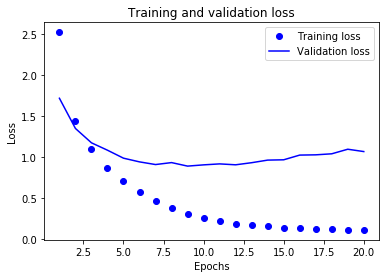

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

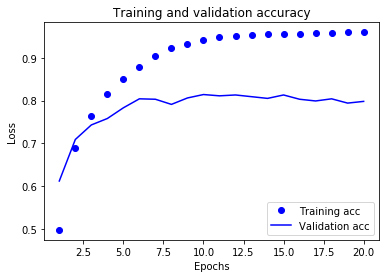

In [22]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

网络在训练8 轮后开始过拟合。我们从头开始训练一个新网络，共8个轮次，然后在测试集上评估模型。

In [23]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 267us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/8
7982/7982 [==============================] - 2s 231us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/8
7982/7982 [==============================] - 2s 250us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/8
7982/7982 [==============================] - 2s 228us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/8
7982/7982 [==============================] - 2s 207us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/8
7982/7982 [==============================] - 2s 210us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/8
7982/7982 [==============================] - 2s 231us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [24]:
results

[0.9847470472035191, 0.7845057880676759]


这种方法可以得到约 78% 的精度。对于平衡的二分类问题，完全随机的分类器能够得到50%的精度。但在这个例子中，完全随机的精度约为19%，所以上述结果相当不错，至少和随机的基准比起来还不错。

In [25]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19679430097951914

## Generating predictions on new data

你可以验证，模型实例的 predict 方法返回了在 46 个主题上的概率分布。我们对所有测试数据生成主题预测。

In [26]:
predictions = model.predict(x_test)

predictions 中的每个元素都是长度为 46 的向量。

In [27]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [28]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

In [29]:
np.argmax(predictions[0])

3

## A different way to handle the labels and the loss

前面提到了另一种编码标签的方法，就是将其转换为整数张量，如下所示。

In [30]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


对于这种编码方法，唯一需要改变的是损失函数的选择。对于代码清单 3-21 使用的损失 函数 categorical_crossentropy，标签应该遵循分类编码。对于整数标签，你应该使用 sparse_categorical_crossentropy。

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

这个新的损失函数在数学上与 categorical_crossentropy 完全相同，二者只是接口不同。

In [33]:
y_train[0]

3

In [36]:
y_val[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## On the importance of having sufficiently large intermediate layers

前面提到，最终输出是 46 维的，因此中间层的隐藏单元个数不应该比 46 小太多。现在来 看一下，如果中间层的维度远远小于 46（比如 4 维），造成了信息瓶颈，那么会发生什么？

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 344us/step - loss: 2.7076 - acc: 0.4402 - val_loss: 2.0156 - val_acc: 0.5940
Epoch 2/20
7982/7982 [==============================] - 2s 298us/step - loss: 1.7338 - acc: 0.6191 - val_loss: 1.6568 - val_acc: 0.6110
Epoch 3/20
7982/7982 [==============================] - 2s 294us/step - loss: 1.4676 - acc: 0.6351 - val_loss: 1.5691 - val_acc: 0.6090
Epoch 4/20
7982/7982 [==============================] - 2s 293us/step - loss: 1.3274 - acc: 0.6434 - val_loss: 1.4844 - val_acc: 0.6140
Epoch 5/20
7982/7982 [==============================] - 3s 327us/step - loss: 1.2177 - acc: 0.6496 - val_loss: 1.4570 - val_acc: 0.6230
Epoch 6/20
7982/7982 [==============================] - 3s 335us/step - loss: 1.1279 - acc: 0.6748 - val_loss: 1.4389 - val_acc: 0.6320
Epoch 7/20
7982/7982 [==============================] - 2s 285us/step - loss: 1.0528 - acc: 0.6937 - val_loss: 1.4564 - val_acc: 0.6360



现在网络的验证精度最大约为 71%，比前面下降了 8%。导致这一下降的主要原因在于，你试图将大量信息（这些信息足够恢复 46 个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。

## Further experiments

* 尝试使用更多或更少的隐藏单元，比如 32 个、128 个等。

* 前面使用了两个隐藏层，现在尝试使用一个或三个隐藏层。

## Wrapping up


下面是你应该从这个例子中学到的要点。

* 如果要对 N 个类别的数据点进行分类，网络的最后一层应该是大小为 N 的 Dense 层。
* 对于单标签、多分类问题，网络的最后一层应该使用 softmax 激活，这样可以输出在 N个输出类别上的概率分布。
* 这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的 真实分布之间的距离最小化。
* 处理多分类问题的标签有两种方法。
* 通过分类编 码（也叫 one-hot 编码）对标签进行编码，然后使用 categorical_crossentropy 作为损失函数。
* 将标签编码为整数，然后使用 sparse_categorical_crossentropy 损失函数。
* 如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈。